In [1]:
#conda install -c saravji pmdarima

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import math
from datetime import date, timedelta

In [2]:
KODE = 'BBNI.JK'
today_date = date.today()
td = timedelta(160)
mulai = today_date - td

In [4]:
import yfinance as yf
data = yf.download(KODE, start=mulai, end = today_date)
datam = yf.download(KODE, period="max", auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-03,6850.0,6875.0,6725.0,6725.0,6603.161621,12620900
2021-12-06,6725.0,6925.0,6725.0,6850.0,6725.896973,26793800
2021-12-07,6900.0,7050.0,6850.0,7050.0,6922.273438,26352300
2021-12-08,7050.0,7075.0,6850.0,6850.0,6725.896973,34631800
2021-12-09,6900.0,6900.0,6800.0,6825.0,6701.349609,11498000


In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-27,9600.0,9625.0,9400.0,9450.0,9450.0,51713300
2022-04-28,9450.0,9550.0,9150.0,9225.0,9225.0,70120800
2022-05-09,9000.0,9000.0,8650.0,8825.0,8825.0,104526000
2022-05-10,8350.0,8900.0,8350.0,8900.0,8900.0,83171500
2022-05-11,8950.0,9200.0,8750.0,8775.0,8775.0,34802100


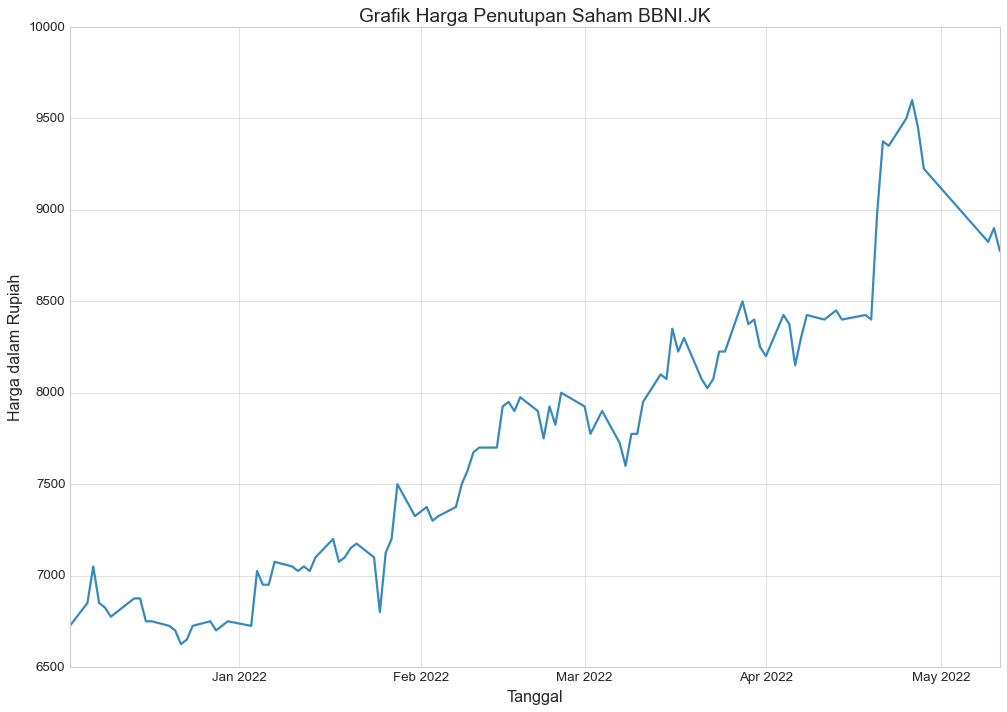

In [24]:
#plot harga penutupan
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,10))
plt.grid(True)
plt.xlabel('Tanggal')
plt.ylabel('Harga dalam Rupiah')
plt.plot(data['Close'])
plt.title('Grafik Harga Penutupan Saham '+KODE)
plt.show()

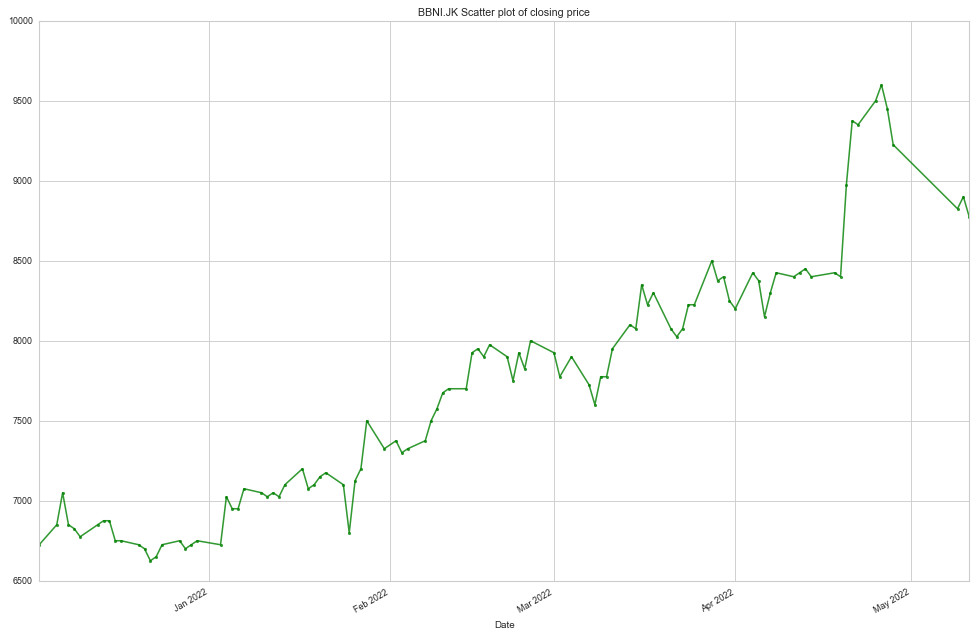

In [43]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn-paper')
df_close = data['Close']
df_close.plot(style='k.-', alpha=0.8, c='green')
plt.title(KODE + ' Scatter plot of closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

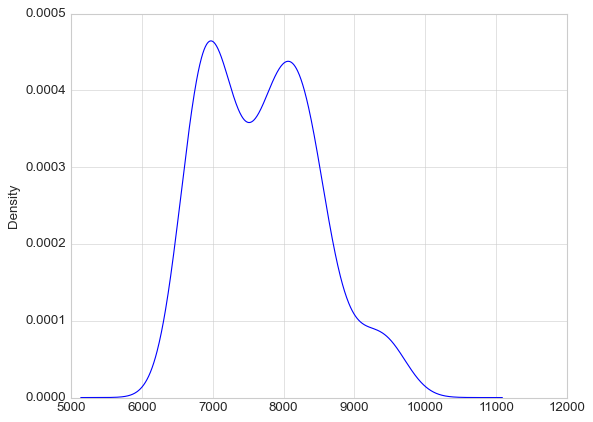

In [59]:
#Distribution of the dataset
df_close = data['Close']
df_close.plot(kind='kde')

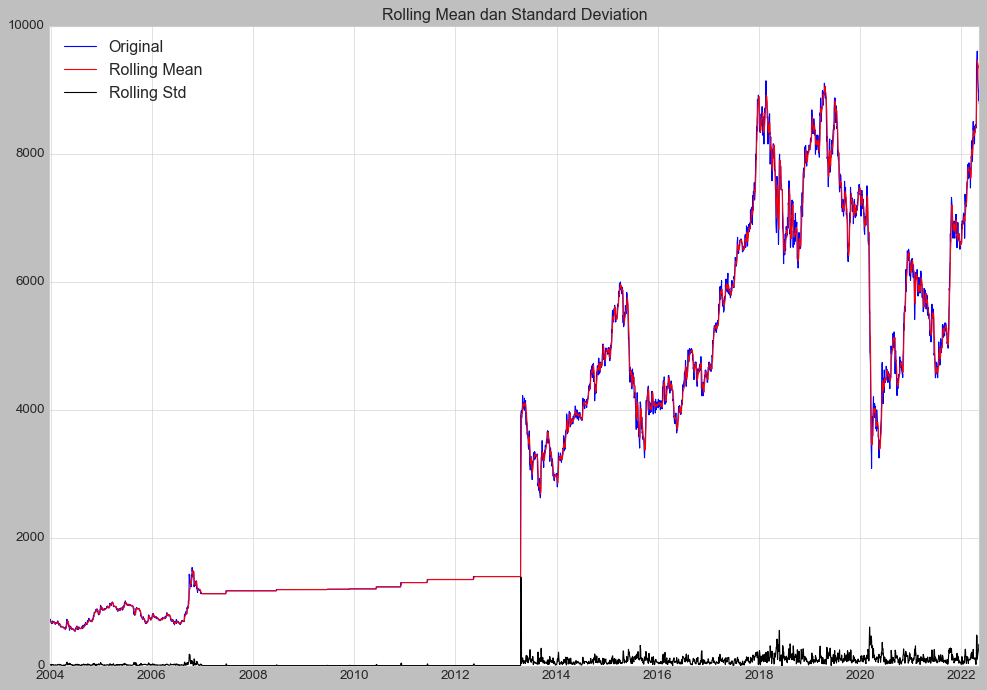

Results of dickey fuller test
Test Statistics                  -0.543922
p-value                           0.883157
No. of lags used                  1.000000
Number of observations used    4561.000000
critical value (1%)              -3.431785
critical value (5%)              -2.862174
critical value (10%)             -2.567107
dtype: float64


In [57]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

#Test untuk staionarity
def test_stationarity(timeseries):
    #Determinasi rolling statistics
    warnings.filterwarnings('ignore')
    rolmean = timeseries.rolling(5).mean()
    rolstd = timeseries.rolling(5).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(15,10))
    plt.style.use('seaborn-whitegrid')
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean dan Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 640x440 with 0 Axes>

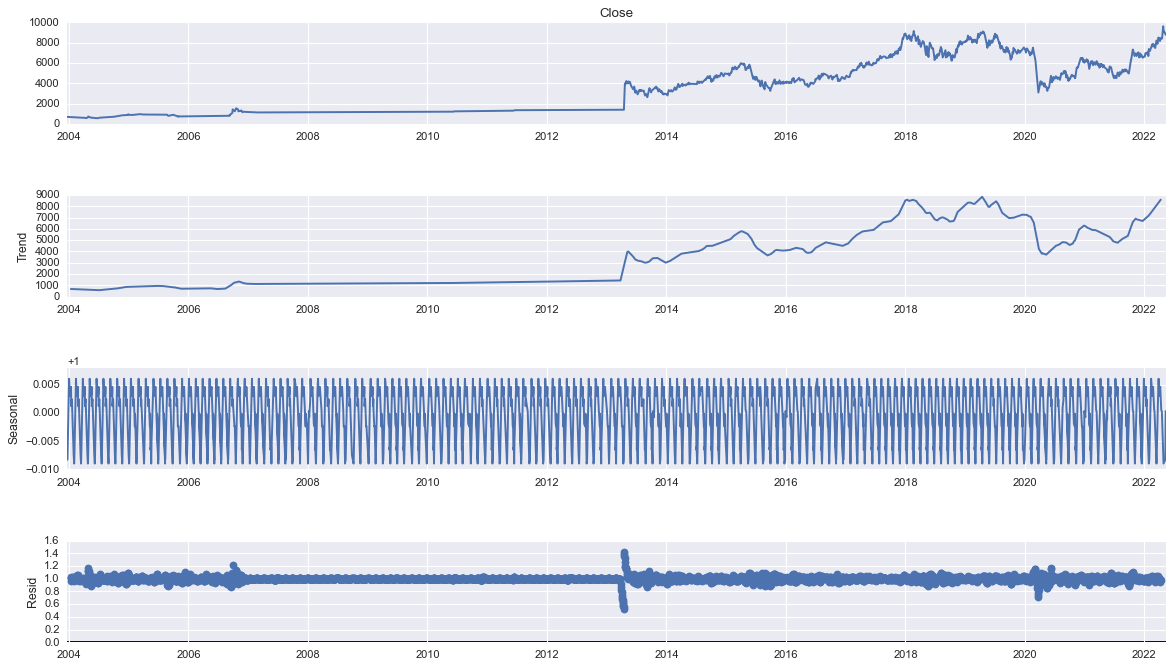

In [46]:
df_close = datam['Close']
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
plt.style.use('seaborn')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


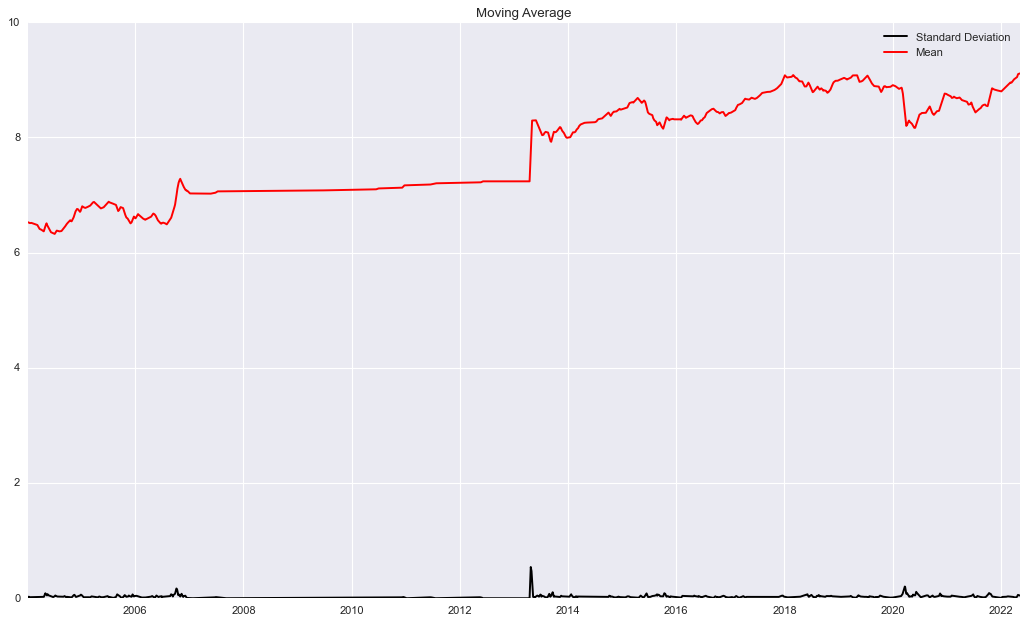

In [47]:
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend(loc='best')
plt.show()

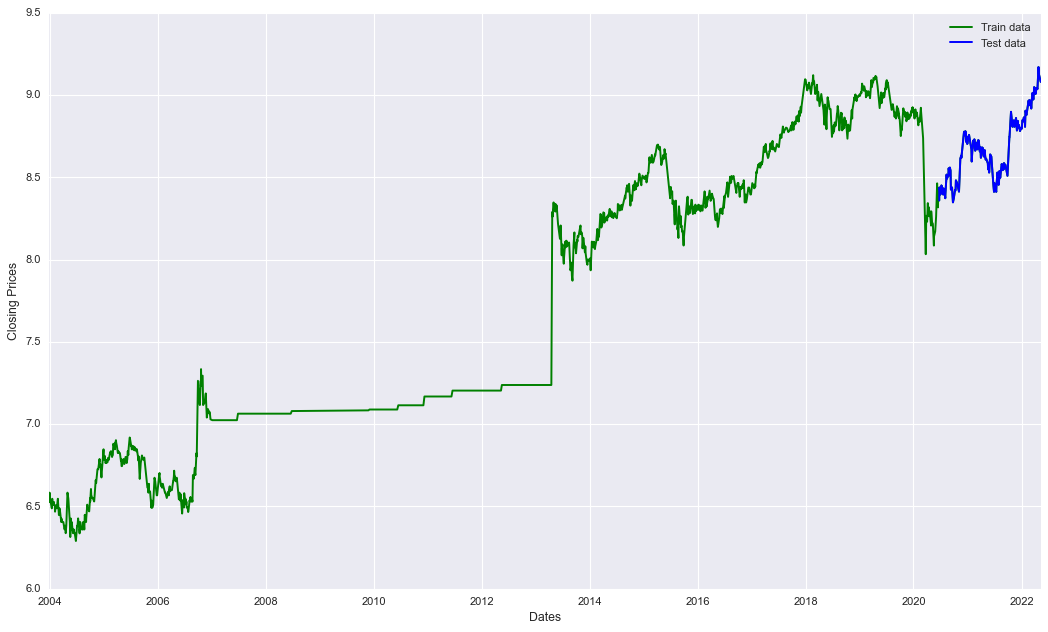

In [48]:
#split data jadi data train dan data training
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(16,9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [13]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                             test='adf',       # gunakan adf test untuk mencari nilai optimal 'd'
                             max_p=3, max_q=3, # maximum p dan q
                             m=1,              # frequency dari data series
                             d=None,           # Biarkan model untuk 'd' none
                             seasonal=False,   # Tidak ada data musiman
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True,
                             stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18875.169, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18873.511, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18873.503, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18875.745, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18871.507, Time=0.84 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.997 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4103
Model:               SARIMAX(0, 1, 0)   Log Likelihood                9438.872
Date:                Thu, 12 May 2022   AIC                         -18875.745
Time:                        04:42:39   BIC                         -18869.425
Sample:                             0   HQIC                        -18873.508
                               - 4103                             

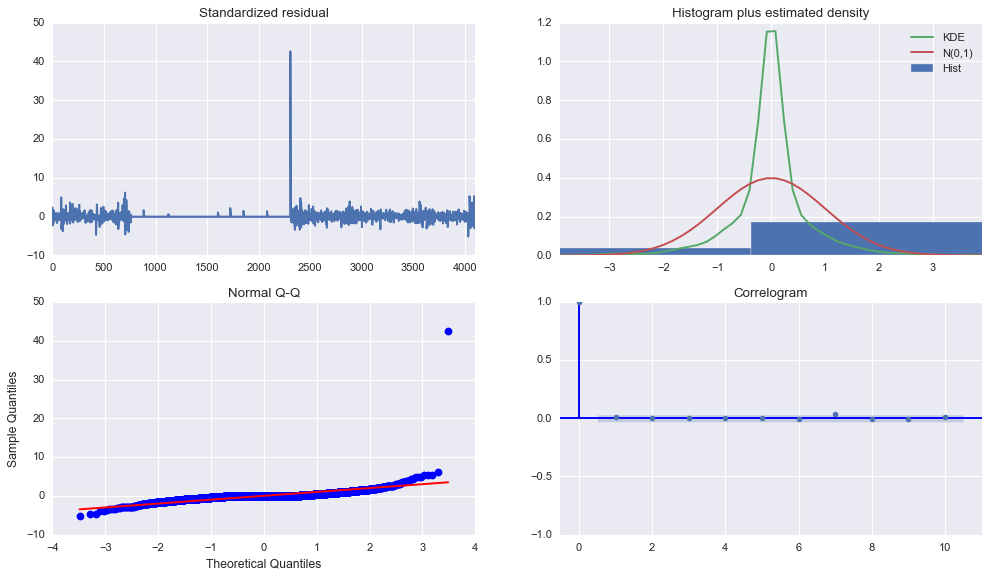

In [49]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [15]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4102
Model:                 ARIMA(0, 1, 0)   Log Likelihood                9439.584
Method:                           css   S.D. of innovations              0.024
Date:                Thu, 12 May 2022   AIC                         -18875.169
Time:                        04:42:48   BIC                         -18862.530
Sample:                             1   HQIC                        -18870.694
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.193      0.233      -0.000       0.001


In [60]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(0, 0, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 4103
Model:                     ARMA(0, 0)   Log Likelihood               -5127.137
Method:                           css   S.D. of innovations              0.844
Date:                Thu, 12 May 2022   AIC                          10258.275
Time:                        08:25:29   BIC                          10270.914
Sample:                             0   HQIC                         10262.749
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6708      0.013    582.014      0.000       7.645       7.697


In [61]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4102
Model:                 ARIMA(1, 1, 1)   Log Likelihood                9439.825
Method:                       css-mle   S.D. of innovations              0.024
Date:                Thu, 12 May 2022   AIC                         -18871.651
Time:                        08:26:56   BIC                         -18846.374
Sample:                             1   HQIC                        -18862.702
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.189      0.235      -0.000       0.001
ar.L1.D.Close    -0.7110      0.332     -2.142      0.032      -1.362      -0.060
ma.L1.D.Close     0.7187      0.328     

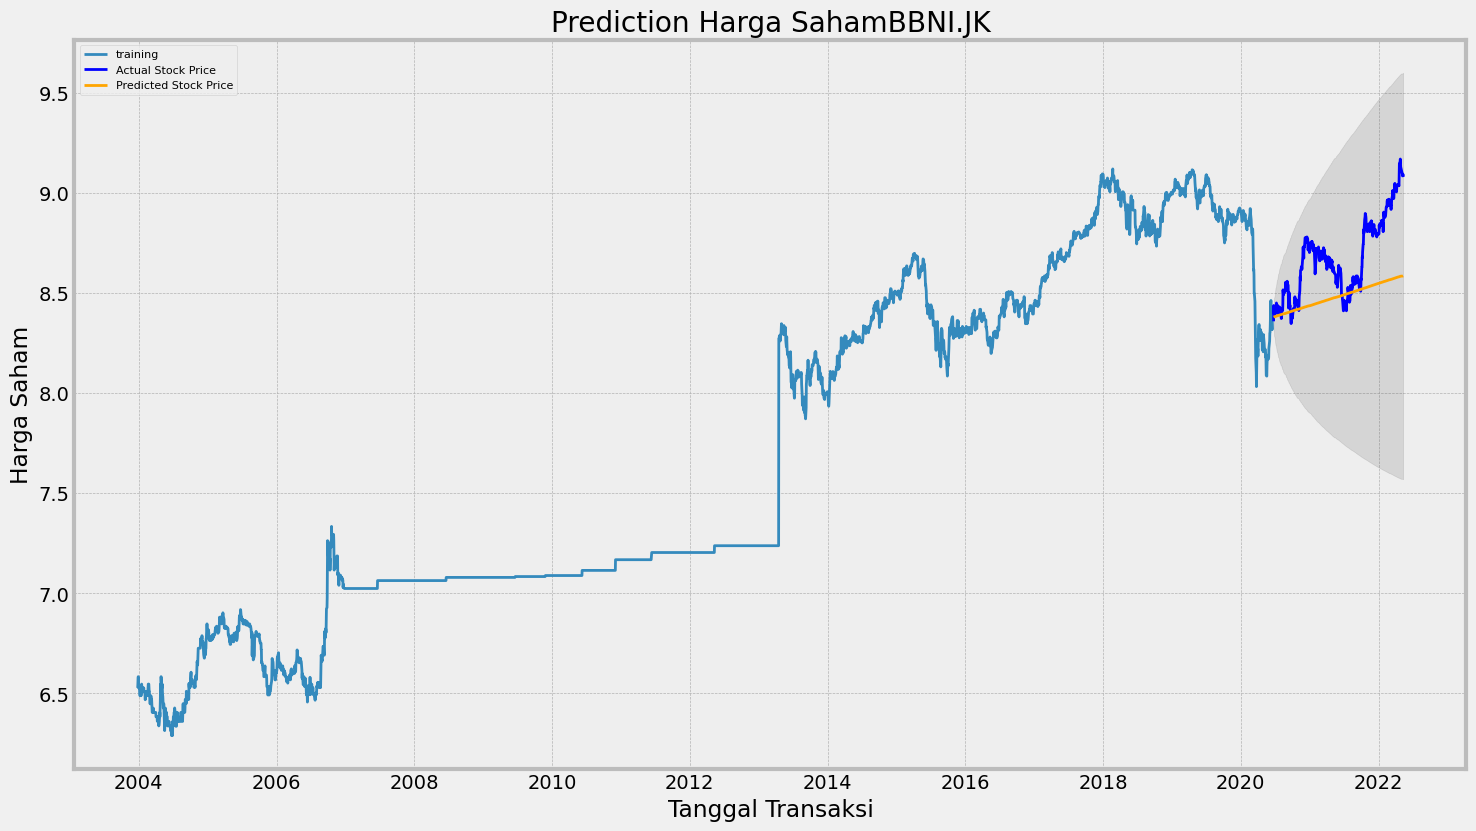

In [16]:
# Forecast
fc, se, conf = fitted.forecast(test_data.shape[0], alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(16,9), dpi=100)
plt.style.use('bmh')
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)

plt.title('Prediction Harga Saham' + KODE)
plt.xlabel('Tanggal Transaksi')
plt.ylabel('Harga Saham')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE  : '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE  : '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE : '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE : '+str(mape))

MSE  : 0.057909133091137925
MAE  : 0.1942379342949402
RMSE : 0.24064316547772124
MAPE : 0.022066400606365447


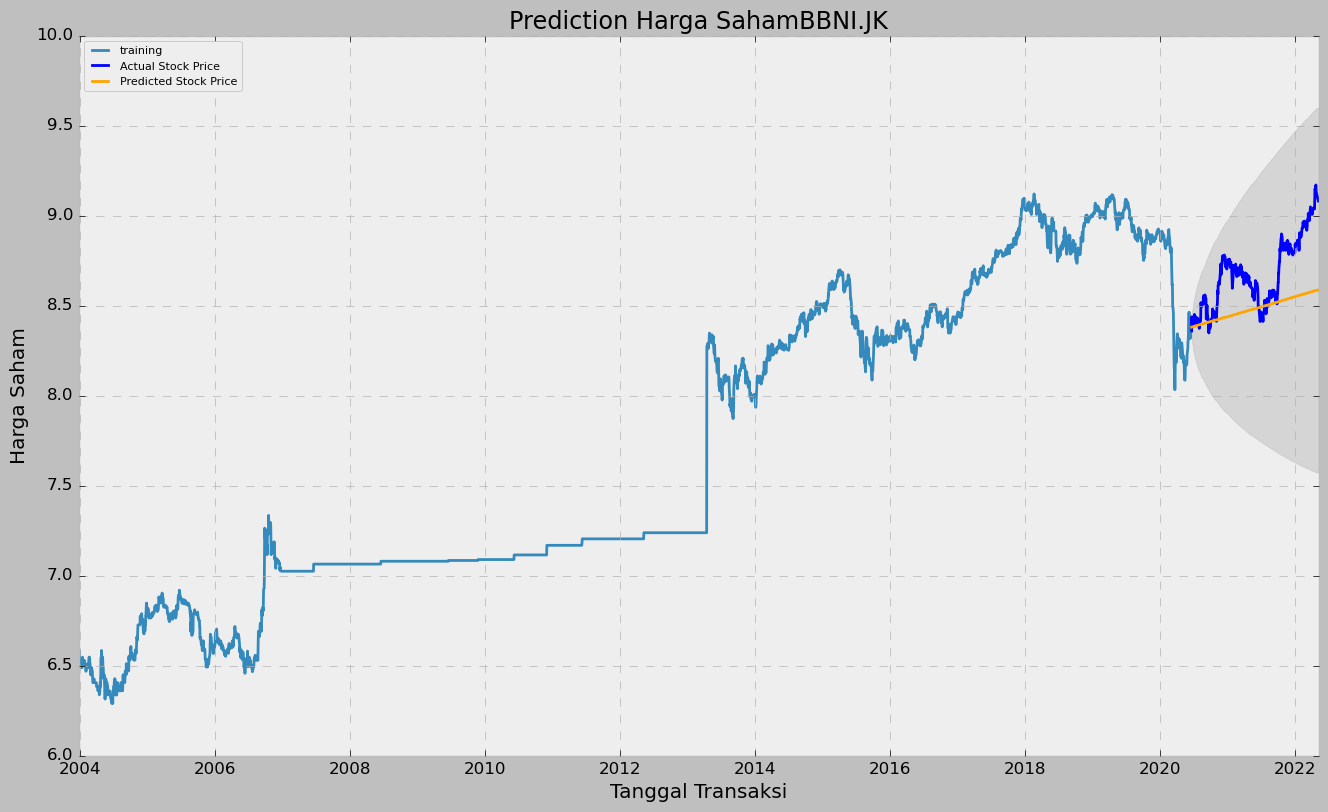

In [20]:
# Prediksi
plt.style.use('classic')
fc, se, conf = fitted.forecast(test_data.shape[0], alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(16,9), dpi=100)
plt.style.use('bmh')
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)

plt.title('Prediction Harga Saham' + KODE)
plt.xlabel('Tanggal Transaksi')
plt.ylabel('Harga Saham')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [64]:
import pandas as pd
s = pd.Series(fc)
s.describe()

count    457.000000
mean       8.482594
std        0.059624
min        8.379660
25%        8.431127
50%        8.482594
75%        8.534061
max        8.585528
dtype: float64

In [76]:
a = s.describe().loc['mean']*1000
b = s.describe().loc['max']*1000
c = s.describe().loc['min']*1000

print(f'Estimasi Harga Rata-Rata Rp.{a:.2f} per Lembar Saham')
print(f'Estimasi Harga Saham Tertinggi Rp.{b:.2f} per Lembar Saham')
print(f'Estimasi Harga Saham Terendah Rp.{c:.2f} per Lembar Saham')

Estimasi Harga Rata-Rata Rp.8482.59 per Lembar Saham
Estimasi Harga Saham Tertinggi Rp.8585.53 per Lembar Saham
Estimasi Harga Saham Terendah Rp.8379.66 per Lembar Saham
